<a href="https://colab.research.google.com/github/Debrup-commits/MNIST-based-Hand-written-digit-detection-CNN/blob/main/MNIST_Number_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports


In [ ]:
import torch
from torchvision import datasets
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import optim
from torch.autograd import Variable



In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

#The Datasets

In [ ]:

train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = transforms.ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = transforms.ToTensor()
)

print(train_data)
print(test_data)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


#Shape of the datasets

In [ ]:
print(train_data.data.shape)
print(train_data.targets.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


#Visualisation

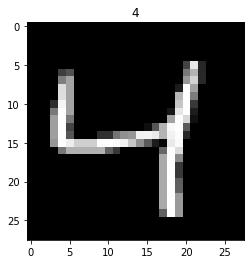

In [ ]:
#visualising a single image(Here, the third image in the dataset)
plt.imshow(train_data.data[2], cmap='gray')
plt.title('%i' % train_data.targets[2])
plt.show()

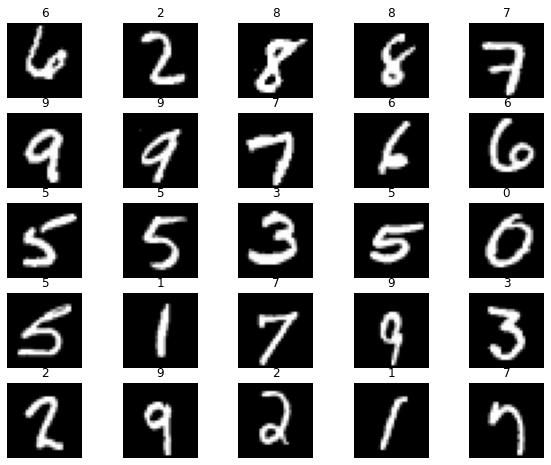

In [ ]:
#visualising multiple images
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

#Train & Test Loaders

In [ ]:
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'test': <torch.utils.data.dataloader.DataLoader at 0x7f797ba278d0>,
 'train': <torch.utils.data.dataloader.DataLoader at 0x7f787a7ffb50>}

#Our NN Model

In [ ]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

In [ ]:
model = MyModel()
print(model)

MyModel(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [ ]:
#Loss function
loss_func = nn.CrossEntropyLoss()   
loss_func

CrossEntropyLoss()

In [ ]:
optimizer = optim.Adam(model.parameters(), lr = 0.01)   
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)

#Training

In [ ]:
num_epochs = 10

def train(num_epochs, cnn, loaders):
    
    model.train()
        
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = model(b_x)[0]               
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Progress: {}/{} ({:.2f}%), Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, 100*(i+1)/total_step, loss.item()))
                pass
        
        pass
    
    
    pass
train(num_epochs, model, loaders)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1/10], Progress: 100/600 (16.67%), Loss: 0.1212
Epoch [1/10], Progress: 200/600 (33.33%), Loss: 0.1431
Epoch [1/10], Progress: 300/600 (50.00%), Loss: 0.0693
Epoch [1/10], Progress: 400/600 (66.67%), Loss: 0.2134
Epoch [1/10], Progress: 500/600 (83.33%), Loss: 0.0395
Epoch [1/10], Progress: 600/600 (100.00%), Loss: 0.0802
Epoch [2/10], Progress: 100/600 (16.67%), Loss: 0.0587
Epoch [2/10], Progress: 200/600 (33.33%), Loss: 0.1016
Epoch [2/10], Progress: 300/600 (50.00%), Loss: 0.0328
Epoch [2/10], Progress: 400/600 (66.67%), Loss: 0.0407
Epoch [2/10], Progress: 500/600 (83.33%), Loss: 0.1019
Epoch [2/10], Progress: 600/600 (100.00%), Loss: 0.1154
Epoch [3/10], Progress: 100/600 (16.67%), Loss: 0.1307
Epoch [3/10], Progress: 200/600 (33.33%), Loss: 0.0990
Epoch [3/10], Progress: 300/600 (50.00%), Loss: 0.0795
Epoch [3/10], Progress: 400/600 (66.67%), Loss: 0.0198
Epoch [3/10], Progress: 500/600 (83.33%), Loss: 0.0351
Epoch [3/10], Progress: 600/600 (100.00%), Loss: 0.0933
Epoch [

#Testing

In [ ]:
def test():
    # Test the model
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            test_output, last_layer = model(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            pass
    print('Test Accuracy of the model on the 10000 test images: {%.2f}',format(accuracy))
    
    pass
test()

Test Accuracy of the model on the 10000 test images: {%.2f} 0.99


#Sample ground truth array

In [ ]:
sample = next(iter(loaders['test']))
imgs, lbls = sample

In [ ]:
actual_number = lbls[:10].numpy()
actual_number

array([3, 7, 5, 9, 2, 5, 8, 3, 4, 0])

#Testing our model

#Prediction over a single image

In [ ]:
test_output, last_layer = model(imgs[54:55])

#prediction
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()

#ground truth
gt = lbls[54:55].numpy()

print(f'Actual number: {gt}')
print(f'Prediction number: {pred_y}')

Actual number: [1]
Prediction number: 1


#Prediction over multiple images

In [ ]:
test_output, last_layer = model(imgs[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(f'Prediction number: {pred_y}')
print(f'Actual number: {actual_number}')

Prediction number: [3 7 5 9 2 5 8 3 4 0]
Actual number: [3 7 5 9 2 5 8 3 4 0]
